# Main Code 
* This notebook shelters code for following functionalities
* Download tweets using Twitter API
* Preprocess tweets to remove noise & standardize
* Data Exploration - Vizualize Frequency Distributions & Histogram for Hashtags, Location & Tweet tokens
* Data Exploration - Hashtag coocurance heatmap
* Vader Sentiment Analysis
* LDA Topic Modelling
* Trend Analysis
* Geotag analysis

#### Some non-regular dependency to run the notebook - GeoPy, IPyleaflet

In [1]:
%load_ext autoreload
%autoreload 1
%aimport twitterClient
%aimport TwitterProcessing

# To display output of all the statements and not only last statement
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# supress warnings
import warnings
warnings.simplefilter("ignore")

# import required packages
import re
import csv
import sys
import json
import math
import glob
import string
import codecs
import datetime
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from tweepy import Cursor
from itertools import chain
from operator import itemgetter
from collections import Counter

# natural language processing packages
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# packages for tweet analysys
import tweepy as tw
from tweepy import api
from twitterClient import twitterClient

# Topic Modelling
import pyLDAvis.sklearn
from wordcloud import WordCloud
from argparse import ArgumentParser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# visualisation packages
import matplotlib.dates as mdates
from geopy.geocoders import Nominatim
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt; plt.rcdefaults()
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, MarkerCluster, SplitMapControl


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jigar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jigar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
G:\Anaconda\lib\site-packages\pkg_resources\__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
G:\Anaconda\lib\site-packages\pkg_resources\__init__.py:1151: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
G:\Anaconda\lib\site-packages\ipyleaflet\leaflet.py:92: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  options = List(trait=Unicode).tag(sync=Tru

In [2]:
def twitterAuth():
    """
        Author - Jeffery Chan
        Reference - J. Chan, " COSC2671 | Social Media and Network Analytics, Class Notes (Internal)[Accessed: 26- Aug- 2019]
    
        Setup Twitter API authentication.
        Replace keys and secrets with your own.

        @returns: tweepy.OAuthHandler object
    """
    
    try:
        consumerKey = "4KvUNbNFVKthKIPTzss9gO2e9"
        consumerSecret = "vr7lXG9jJtBSOjx5jxJIUoidAlTh85AOZoFnA3U8xg6wdIxZcE"
        accessToken = "2607948770-NGAAsCP3zP07ThHJvQWedkN7vj5zW0ovtaMmxBE"
        accessSecret = "pKTvLsbPGCTDBVqFcuEotKjBYM45xoXQkDvyccrWjvFUb"
    except KeyError:
        sys.stderr.write("Key or secret token are invalid.\n")
        sys.exit(1)

    auth = tw.OAuthHandler(consumerKey, consumerSecret)
    auth.set_access_token(accessToken, accessSecret)

    return auth

def twitterClient():
    """
        Author - Jeffery Chan
        Reference - J. Chan, " COSC2671 | Social Media and Network Analytics, Class Notes (Internal)[Accessed: 26- Aug- 2019]
        
        Setup Twitter API client.

        @returns: tweepy.API object
    """

    auth = twitterAuth()
    client = tw.API(auth, wait_on_rate_limit=True)

    return client

def getHashtags(tweet):
    """
    Author - Jeffery Chan
    Reference - J. Chan, " COSC2671 | Social Media and Network Analytics, Class Notes (Internal)[Accessed: 26- Aug- 2019]
    
    Extracts the associated hashtags of tweet.

    @param tweet: The tweet, which is in the tweepy json format, and which we wish to extract its associated hashtags.

    @returns: list of hashtags (in lower case)
    """
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])

    return [tag['text'].lower() for tag in hashtags]


def getLocation(tweet):
    """
    Extracts the associated hashtags of tweet.

    @param tweet: The tweet, which is in the tweepy json format, and which we wish to extract its associated hashtags.

    @returns: list of hashtags (in lower case)
    """
    user = tweet.get('user', {})
    loc = user.get('location')
#     reg = str.lower(loc).split(',')[0]
    return loc




In [3]:
def dataFetch(fileName, query, itemCount):
    """

    Method to laod data from twitter

    @param fileName: JSON file name where tweets are to be stored
    @param query: twitter hashtag or handle for which data will be fetched
    @param itemCount: Number of tweets to be retrived

    """
    
    client = twitterClient()
    f = open(fileName,"w")
    global tweetCount
    for tweet in Cursor(client.search, q=query, lang='en').items(itemCount):
        if tweet.lang == 'en':
            json.dump(tweet._json, f)
            f.write("\n")
            tweetCount += 1
    #Display how many tweets we have collected
    print("Downloaded {0} tweets".format(tweetCount))
    f.close()
    return

In [4]:
def processTweets(fileName):
    """
    
    Perform tokenisation, normalisation (lower case and stemming) and stopword and twitter keyword removal.

    @param text: tweet text
    @param tokenizer: tokeniser used.
    @param stemmer: stemmer used.
    @param stopwords: list of stopwords used

    @returns: A dataframe with features - DateTime, Tokens, Hashtags, Location
    """
    global totalTermsCount
    global filteredTermsCount
    global wordLength
    global tweetLength
    global hashtagsOuter
    
   
    wordLength = []
    tweetLength = []
    listOfTokens = []
    hashtagsOuter = []

    # Data Stats
    totalTermsCount = 0
    filteredTermsCount = 0 
    
    lPunct = list(string.punctuation)
    tweetStemmer = nltk.stem.PorterStemmer()
    tweetTokeniser = nltk.tokenize.TweetTokenizer()
    lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", "_"]
    location = []
    hashtags = []
    listOfTokens = []
    date = []
    with open(fileName, 'r') as f:
        for line in f:
            tweet = json.loads(line)
            tweetText = tweet.get('text', '')
            
            tweetDate = tweet.get('created_at')  
            
            hashtagsOuter.append(getHashtags(tweet))

            # covert all to lower case
            tweetText = tweetText.lower()
            
            # tokenise
            lTokens = tweetTokeniser.tokenize(tweetText)
            
            # strip whitespaces before and after
            lTokens = [token.strip() for token in lTokens]
            totalTermsCount += len(lTokens)
            tweetLength.append(len(lTokens))
            for token in lTokens:
                wordLength.append(len(token))
            # Emoticon Filter
            regexEmoji = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

            # digit filter
            regexDigit = re.compile(r"^\d+\s|\s\d+\s|\s\d+$")

            # URL filter
            regexHttp = re.compile("^http")
            
            # @Handle mentions & Hashtags
            regexTweetHandles = re.compile("^@|^#")
            
            # stem (we use set to remove duplicates)
            # lStemmedTokens = set([tweetStemmer.stem(tok) for tok in lTokens if tok not in lStopwords])
            lStemmedTokens = set([tok for tok in lTokens if tok not in lStopwords])
            
            # Remove digits, urls, emoticons            
            filterdTokens = [tok for tok in lStemmedTokens if not tok.isdigit() and regexDigit.match(tok) == None and regexHttp.match(tok) == None and regexEmoji.match(tok) == None and regexTweetHandles.match(tok) == None]
            
            filteredTermsCount += len(filterdTokens)
            date.append(tweetDate)
            location.append( getLocation(tweet).split(","))
            hashtags.append(getHashtags(tweet))
            listOfTokens.append(filterdTokens)
    
    df = pd.DataFrame({'date':date, 'tokens':listOfTokens, "hashtags":hashtags, "location":location})
    print("Unfiltered Term count", totalTermsCount)
    print("Filtered Term Count",filteredTermsCount)
    print("Average Tweet Length in words (Unfiltered)", round(totalTermsCount/len(listOfTokens),3))
    print("Average Tweet Length in words (filtered)", round(filteredTermsCount/len(listOfTokens),3))
    
    return df

mainDF = processTweets('climatechange.json')

Unfiltered Term count 585203
Filtered Term Count 219182
Average Tweet Length in words (Unfiltered) 23.408
Average Tweet Length in words (filtered) 8.767


In [5]:
def visTermFreq(termCount, listOfTokens, titleString):
    """
    
    Creates a barplot for listOfToken list, assigns appropriate title.

    @param termCount: Direct counter
    @param listOfTokens: List of tokens for which the plot is to be generated
    @param titleString: Title of generated plot
    """
    
    tokenFreqCounter = collections.Counter(listOfTokens)
    termList = []
    termFreqCount = []

    for term, count in tokenFreqCounter.most_common(termCount):
        termList.append(term)
        termFreqCount.append(count)
        
    wordCount = pd.DataFrame(list(zip(termList, termFreqCount)), index = list(range(0,len(termList))))
    wordCount.columns = ['termList','termFreqCount']

    plt.figure(figsize=(15,5))
    count_y = np.arange(len(wordCount['termList'])) 
    plt.bar(count_y,wordCount['termFreqCount'])
    plt.xticks(count_y, wordCount['termList'], rotation='60')
    plt.title("Frequency of most common " + titleString)
    plt.xlabel(titleString)
    plt.ylabel("Frequency")
    plt.show();


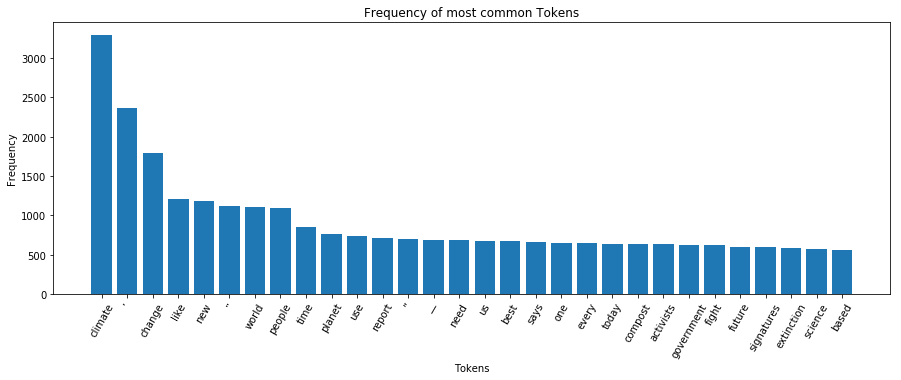

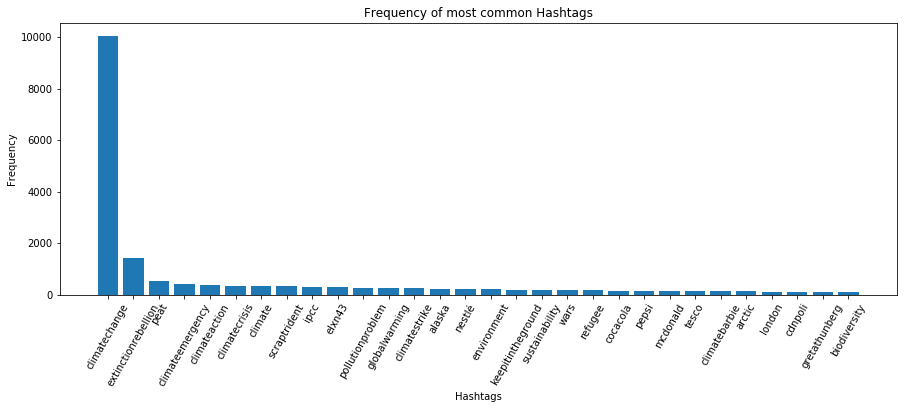

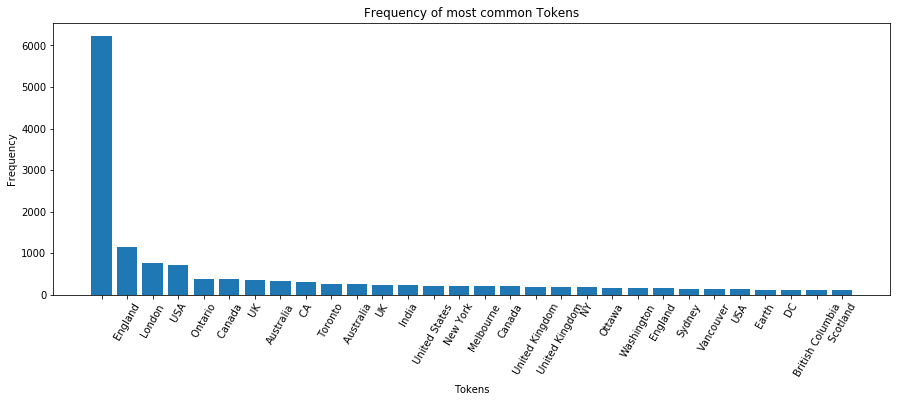

In [8]:
visTermFreq(30, list(itertools.chain.from_iterable(mainDF['tokens'])), "Tokens")
visTermFreq(30, list(itertools.chain.from_iterable(mainDF['hashtags'])), "Hashtags")
visTermFreq(30, list(itertools.chain.from_iterable([i for i in mainDF['location'] if i != ''])), "Tokens")


In [9]:
def produceCoocurranceHeatmap(listOfHashtags):
    """
        Author - Jigar
        
        Produces 2nd degree co-occurance matrix (heatmap) from a double packed list (list of list of tokens)
    """
    vectors = []
    tweetHashtagList = listOfHashtags
    
    # Unpack list of list of hashtags to list of hash tags
    hashtagFreqCounter = collections.Counter(list(itertools.chain.from_iterable(listOfHashtags)))
    
    filteredHashtags = [i for i in tweetHashtagList if i]
    mostCommon = list(dict(hashtagFreqCounter.most_common(30)).keys())

    # Vectorize the counter
    for i in filteredHashtags:
        vectors.append([0] * 30)
        for tag in i:
            if tag in mostCommon:
                vectors[-1][mostCommon.index(tag)] = 1
    
    # Convert to long format
    dfHeat = pd.DataFrame(vectors, columns = mostCommon)

    # Pivot and prepare co-occurance matrix
    dfHeatFl = dfHeat.T.dot(dfHeat)

    # plot the correlation matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(dfHeatFl,
        cmap= 'gist_heat_r',
        vmax = 100,
        square = True,
        cbar_kws={'label':'correlation'})
    plt.show();

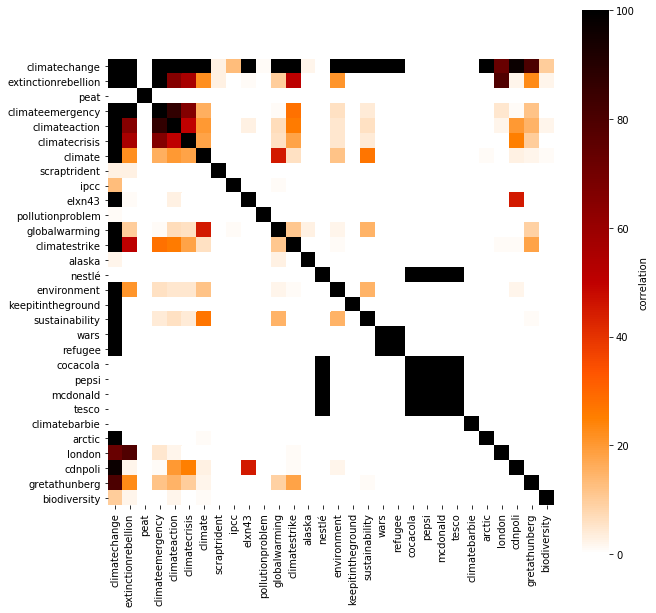

In [10]:
produceCoocurranceHeatmap(mainDF['hashtags'])

In [11]:
def display_topics(lTokens, numTopics):
    """

    Author - Jeffery Chan
    Reference - J. Chan, " COSC2671 | Social Media and Network Analytics, Class Notes (Internal)[Accessed: 26- Aug- 2019]
    
    Prints out the most associated words for each feature.
    
    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """
    lTweets = []
    for tupleItem in lTokens:
        lTweets.append(' '.join(tupleItem))

    # params for LDA
    topicNum = numTopics
    wordNumToDisplay = 15
    featureNum = 1500

    #counting via CountVectorizer
    tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
    tf = tfVectorizer.fit_transform(lTweets)
    # extract the names of the features (in our case, the words)
    tfFeatureNames = tfVectorizer.get_feature_names()
    
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """
    # LDA model  
    model = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)
    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([tfFeatureNames[i] for i in lTopicDist.argsort()[:-wordNumToDisplay - 1:-1]]))
    
    # components to display wordcloud
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    plotColNum = 2
    plotRowNum = int(math.ceil(topicNum / plotColNum))
    plt.figure(figsize = (25,15))
    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {tfFeatureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='white')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
    plt.show(block=True);
    

Topic 0:
climate change action new carbon great kids global scientist government level protest ways actually starts
Topic 1:
based planet compost today signatures seriously given petition ban realise enor 217 future need year
Topic 2:
climate people best like says change read protesters dr looks big energy drought countries word
Topic 3:
world activists polar use know forests good meeting amazon unprecedented moral rome pope fate francis
Topic 4:
time fight saying resources outside locked ministry trident defence mock missile xrpeace leading report waste
Topic 5:
new science extinction rebellion report forum used technology effect society language kyoto 16th glaciers ocean


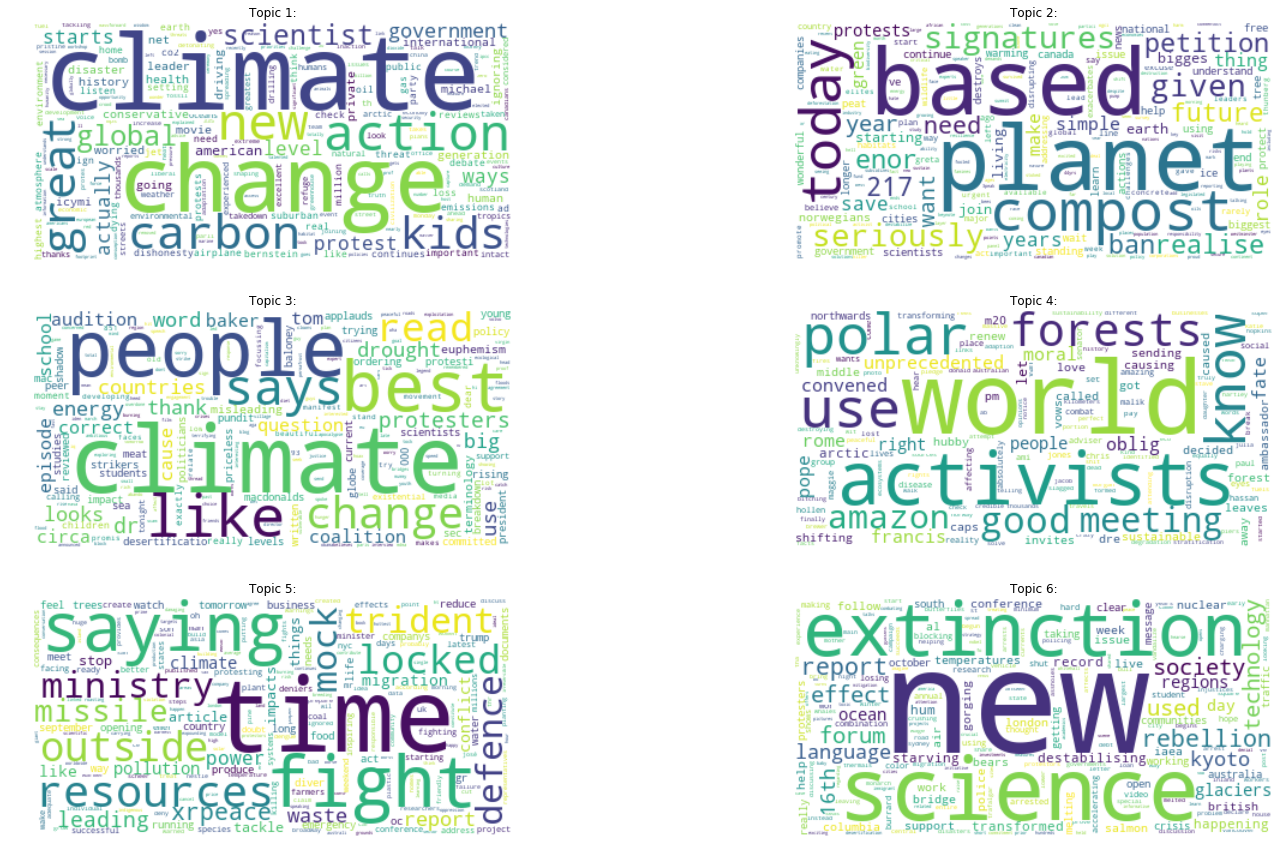

In [12]:

display_topics(list(mainDF['tokens']), 6)

In [117]:
positiveVaderTweets = []
negativeVaderTweets = []
neutralVaderTweets = []
def vaderSentimentAnalysis(tokenizedTweets, bPrint):
    """
    Author - Jeffery Chan
    Reference - J. Chan, " COSC2671 | Social Media and Network Analytics, Class Notes (Internal)[Accessed: 26- Aug- 2019]
    
    Use Vader lexicons instead of a raw positive and negative word count.

    @param sTweetsFilename: name of input file containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """
    
    global positiveVaderTweets, negativeVaderTweets, neutralVaderTweets
    

    overallScore = 0
    
    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    vSentiment = []
    # open file and process tweets, one by one
    overallSentimentScore = 0
    for line in tokenizedTweets:
        try:
            
            lTokens = line

            # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
            # see lab sheet for what dSentimentScores holds
            dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

            # save the date and sentiment of each tweet (used for time series)      
            vSentiment.append(dSentimentScores['compound'])
            overallScore += dSentimentScores['compound']
            
            if dSentimentScores['compound'] > 0.05:
                positiveVaderTweets.append(" ".join(lTokens))
            elif -0.05 <= dSentimentScores['compound'] <= 0.05:
                neutralVaderTweets.append(" ".join(lTokens))
            else:
                negativeVaderTweets.append(" ".join(lTokens))
 
            
            # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
            # of positive and negative words, we cannot use colorama to label each token
            if bPrint:
                print(*lTokens, sep=', ')
                # uncomment this (and comment above line) if you are analysing the tweets directly, instead of the tokens
                for cat,score in dSentimentScores.items():
                    print('{0}: {1}, '.format(cat, score), end='')
                print()
    
        except KeyError as e:
            pass
    print("Overall sentiment orientation calculated = ", overallScore)
    print("Overall Normalized sentiment orientation calculated = ", overallScore/len(tokenizedTweets))
    return vSentiment

def create_word_cloud(string1, title):
    """
        Generate Word clouds based on string

    """
    print(title)
    cloud = WordCloud(background_color = "white", max_words = 30)
    cloud.generate(string1)
    plt.figure(figsize = (10,8))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show();


Overall sentiment orientation calculated =  495.3718000000109
Overall Normalized sentiment orientation calculated =  0.019814872000000438


,Vader Analysis
positive count,9400
neutral count,7309
negative count,8291


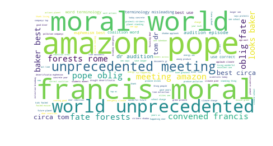

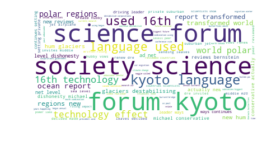

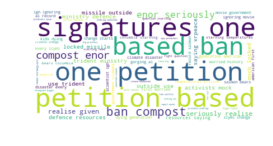

In [14]:
sentiment = vaderSentimentAnalysis(list(mainDF['tokens']),False)
# Comparision between classification by both methods
mainDF['sentiment'] = sentiment
distributionVader = [len(positiveVaderTweets), len(neutralVaderTweets), len(negativeVaderTweets)]

distributionDF = pd.DataFrame( distributionVader,  index = ['positive count','neutral count','negative count'],columns = ['Vader Analysis'])
distributionDF.head()

create_word_cloud(" ".join(positiveVaderTweets), "Positive tweets")
create_word_cloud(" ".join(neutralVaderTweets), "Neutral tweets")
create_word_cloud(" ".join(negativeVaderTweets), "Negative tweets")

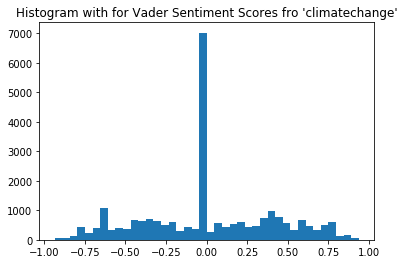

In [15]:
# a = np.hstack()
_ = plt.hist(mainDF['sentiment'], bins=40)  # arguments are passed to np.histogram
plt.title("Histogram with for Vader Sentiment Scores fro 'climatechange'")
# Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show();

### Trend Analysis

In [16]:
llDateTime = []
llTweetsText = []
ldFreq = []

def dateProcess(dateList, tweetTokenList):
    """
    
    Author - Jeffery Chan
    Reference - J. Chan, " COSC2671 | Social Media and Network Analytics, Class Notes (Internal)[Accessed: 26- Aug- 2019]
    
    method tokenizes dates and attaches them to the mainDF
    
    """
    global llDateTime
    global llTweetsText 
    global ldFreq 
    
    lCurrDateTime = []
    lCurrTweetsText = []
    dFreq = Counter()
    previous_date = ""
    
    tokenizer = nltk.tokenize.TweetTokenizer()
    for tweetTokens, date in zip(tweetTokenList, dateList):

        # Split tweet text data on hourly basis for trend analysis
        datetokens = tokenizer.tokenize(date)
        formated_datetime = str(datetokens[0] + '-' + datetokens[1] + '-' + datetokens[2] + '-' + datetokens[6][-4:] + '-' + datetokens[3] + datetokens[4] + datetokens[5]  )
        lCurrTweetsText.append(' '.join(tweetTokens))       

        # frequency of keywords
        dFreq.update(tweetTokens)
        if previous_date != str(datetokens[0] + '-' + datetokens[1] + '-' + datetokens[2] + '-' + datetokens[6][-4:] + '-' + datetokens[3][:2]):
            llDateTime.append(lCurrDateTime)
            llTweetsText.append(lCurrTweetsText)
            ldFreq.append(dFreq)
            lCurrDateTime = []
            lCurrTweetsText = []
            dFreq = Counter()
            previous_date = str(datetokens[0] + '-' + datetokens[1] + '-' + datetokens[2] + '-' + datetokens[6][-4:] + '-' + datetokens[3][:2])
        try:
            # read in datetime format
            dt = datetime.datetime.strptime(formated_datetime, '%a-%b-%d-%Y-%H:%M:%S')
        except ValueError:
            print("cant parse date")
            continue

        # update local structures - datetime
        lCurrDateTime.append(dt)
        
        
dateProcess(mainDF['date'], mainDF['tokens'])

### Trend Analysis Continue

Trending words between times 2019-10-07 00:00:00 and 2019-10-07 00:10:00
Trending words between times 2019-10-07 00:10:00 and 2019-10-07 00:20:00
canada: 12.00
Trending words between times 2019-10-07 00:20:00 and 2019-10-07 00:30:00
Trending words between times 2019-10-07 00:30:00 and 2019-10-07 00:40:00
Trending words between times 2019-10-07 00:40:00 and 2019-10-07 00:50:00
Trending words between times 2019-10-07 00:50:00 and 2019-10-07 01:00:00
elizabeth: 11.00
Trending words between times 2019-10-07 01:00:00 and 2019-10-07 01:10:00
Trending words between times 2019-10-07 01:10:00 and 2019-10-07 01:20:00
Trending words between times 2019-10-07 01:20:00 and 2019-10-07 01:30:00
traffic: 13.00
burrard: 11.00
Trending words between times 2019-10-07 01:30:00 and 2019-10-07 01:40:00
Trending words between times 2019-10-07 01:40:00 and 2019-10-07 01:50:00
Trending words between times 2019-10-07 01:50:00 and 2019-10-07 02:00:00
Trending words between times 2019-10-07 02:00:00 and 2019-10-07

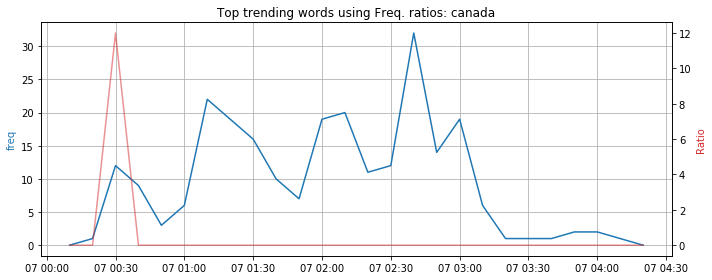

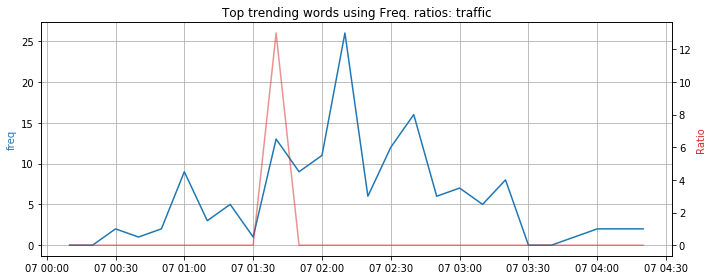

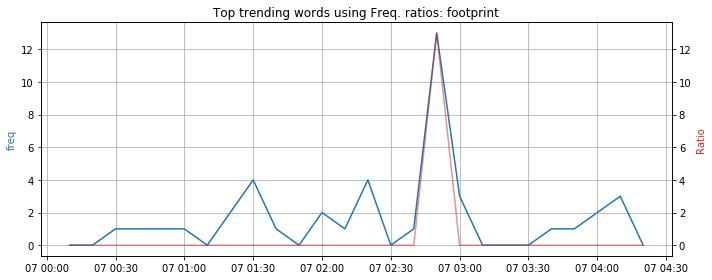

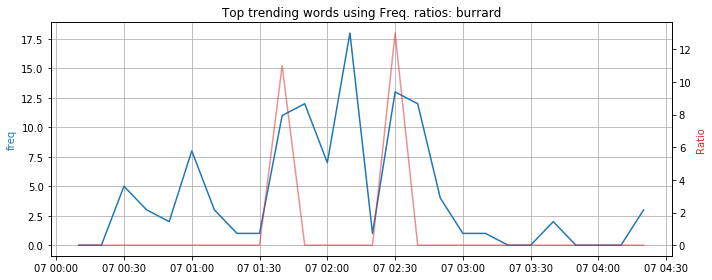

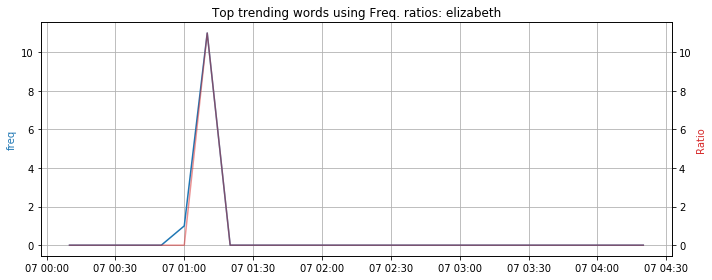

In [25]:
# dateProcess(mainDF['date'],mainDF['tokens'])

releventTokenList = ['traffic','burrard','canada','elizabeth','footprint']

def updateRatio(dWordRatio, key, value):
    """
    
    Author - Jeffery Chan
    Reference - J. Chan, " COSC2671 | Social Media and Network Analytics, Class Notes (Internal)[Accessed: 26- Aug- 2019]
    
    Utility function to update a dictionary that scores maximum values.
    """
    
    # we check if key is in the dictionary then compare if so
    if key in dWordRatio:
        if value > dWordRatio[key]:
            dWordRatio[key] = value
    # otherwise not in dictionary so we can just update the value
    else:
        dWordRatio[key] = value
        

def analyseTrend():
    
    """
    Perform the trend analysis based freq. bursts
    
    Author - Jeffery Chan
    Reference - J. Chan, " COSC2671 | Social Media and Network Analytics, Class Notes (Internal)[Accessed: 26- Aug- 2019]
    
    """
    # threshold to determine if a word is 'trending' between two windows
    # parameter to explore
    trendThresholdFreq = 10
   
    # maximum ratios for each word
    dMaxWordRatio = {}
    
    # time series of ratios for each word, will be used for time series illustration in following cells
    dlWordRatio = {}
    
    # these are used to construct hourly time periods to print out time labels
    startDate = datetime.datetime(year=2019, month=10, day=7, hour=0, minute=0, second=0)
    windowDelta = datetime.timedelta(0, 0, 0, 0, 10, 0)
    endDate = startDate + windowDelta        
    
    # construct dates
    startDate1 = startDate
    endDate1 = startDate1 + windowDelta

    # loop through each adjacent set of 1 hour 'windows'
    for t in range(len(ldFreq)-1):
        # store ratios between each window
        dRatio = {}
        
        expFreq = ldFreq[t]
        obsFreq = ldFreq[t+1]
        
        # need to compute union to ensure we compare all possible words between expected and observed windows/periods
        unionWords = set(expFreq).union(set(obsFreq))

        for word in unionWords:
            dRatio[word] = 0
            # only for the case that expected and observed frequencies are non-zero is the ratio not zero
            if word in expFreq and word in obsFreq:
                dRatio[word] = float(obsFreq[word]) / expFreq[word]
                updateRatio(dMaxWordRatio, word, dRatio[word])

        # print out periods
        print('Trending words between times ' + str(startDate1) + ' and ' + str(endDate1))
        startDate1 = endDate1
        endDate1 = endDate1 + windowDelta

        # print out top words between each window
        for k, v in sorted(dRatio.items(), key=itemgetter(1), reverse=True):
            if v > trendThresholdFreq:
                if k in ['protest','forest','wildfir','traffic','protestor','burrard','reli','desertif',
                         'canada','elizabeth','unab','footprint']:
                    print('{0:s}: {1:.2f}'.format(k,v))
                    # add to word ratios we want to print
                    if k not in dlWordRatio:
                        dlWordRatio[k] = np.zeros(len(ldFreq))    
                    dlWordRatio[k][t+1] = v
    
    """
    Plot keywords frequencies and ratios.
    """

    # number of keywords we want to plot in time series
    keywordNum = 5
    lDates = []
    lKeywords = []
    for w,v in dMaxWordRatio.items():
        if w in releventTokenList:
            lKeywords.append(w)
#     lKeywords = [w for w, v in sorted(dMaxWordRatio.items(), key=itemgetter(1), reverse=True)[:keywordNum]]
    llKeywordFreq = []
    for i in range(len(lKeywords)):
        llKeywordFreq.append([])

    # extract frequency data into a dataframe to plot with pandas
    for i,dFreq in enumerate(ldFreq):
        for j, keyword in enumerate(lKeywords):
            llKeywordFreq[j].append(dFreq[keyword])

    endDate2 = startDate + windowDelta
    for i,dFreq in enumerate(ldFreq):
        lDates.append(endDate2)
        endDate2 = endDate2 + windowDelta

    # plot each figure for keywords
    for k, keyword in enumerate(lKeywords):
        if keyword in releventTokenList:
            idx = pd.DatetimeIndex(lDates)
            mySeries = pd.Series(llKeywordFreq[k], index=idx)
            mySeries2 = pd.Series(dlWordRatio[keyword], index=idx)

            # we plot both frequencies and ratios on the same plot and using the same x-axis (time)
            fig, ax = plt.subplots(figsize=(10,4))
            ax.grid(True)
            ax.set_title("Top trending words using Freq. ratios: " + keyword)
            days = mdates.DayLocator(interval=24)
            date_formatter = mdates.DateFormatter('%m-%d')

            firstColour = 'tab:blue'
            secondColour = 'tab:red'

            # first plot word frequency
            ax.xaxis.set_major_locator(days)
            ax.xaxis.set_major_formatter(date_formatter)
            ax.set_ylabel('freq', color=firstColour)
            ax.plot(mySeries.index, mySeries, color=firstColour)

            # now plot the ratio
            ax2 = ax.twinx()
            ax2.set_ylabel('Ratio', color=secondColour)
            ax2.plot(mySeries.index, mySeries2, color=secondColour, alpha=0.5)

            fig.tight_layout()

analyseTrend()


In [129]:

centerList = {}

def generateCenterList():
    """
    Method to load longitude latitude based coordinates to avoid frequent look up
    
    """
    global centerList
    with open('coordinates.txt', 'r') as fc:
        for line in fc:
            lineData = re.split(':', line[:-1])
            if lineData[0] not in centerList.keys():
                centerList[lineData[0]] = lineData[1]

generateCenterList()               



# hashTokens = {'TweetTokens' : lTweetTokens, 'HashtagList' : tweetHashtagList, 'TweetLoc' : lTweetLoc}
def visTrendingTokLoc(reltoken, inflation):
    """
    Plot hybrid bubble map using IPyleaflet widget
    ** Must be installed correctly. Won't run if proper installation sequence is not followed**
    """
    
    locCoord = []
    tagMarkers = []
    lHashTokenData = []
    for index, row in mainDF.iterrows():  
        if (reltoken in row['tokens']) or (reltoken in row['hashtags']):
            lHashTokenData.append(','.join(tok for tok in row['location']))
    for t in lHashTokenData:
        if t in centerList.keys():
            st = re.split(',',centerList[t][1:-1])
            try:
                locCoord.append(tuple(float(e) for e in st))
            except:
                continue
           
    trendingTokMap = Map(center = locCoord[0], zoom = 1)
    dark_matter_layer = basemap_to_tiles(basemaps.Strava.Winter)
    trendingTokMap.add_layer(dark_matter_layer)
    for val in locCoord:
        tagMarkers.append(Marker(location=val, draggable=False))
    trendingTokMap.add_layer(MarkerCluster(markers=tagMarkers))
    display(trendingTokMap)
    
word = "extinctionrebellion"
print("Global tweet frequency for '"+word+"'")
visTrendingTokLoc(word,9)

# visTrendingTokLoc('climatechange')

Global tweet frequency for 'extinctionrebellion'


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Text(0.5, 1.0, "Histogram for Vader Sentiment Scores for 'protest'")

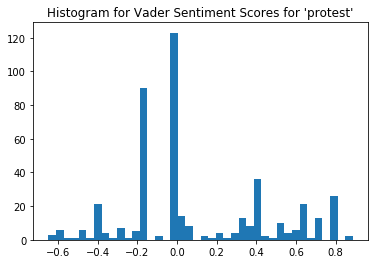

Positive tweets


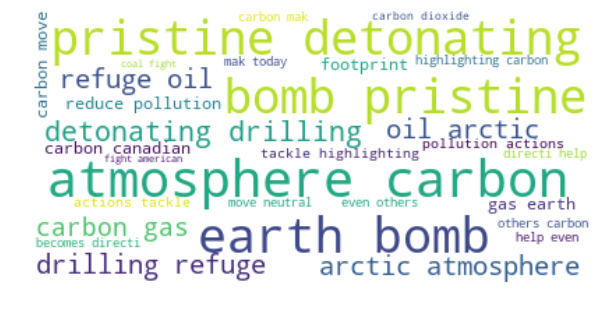

Positive tweets


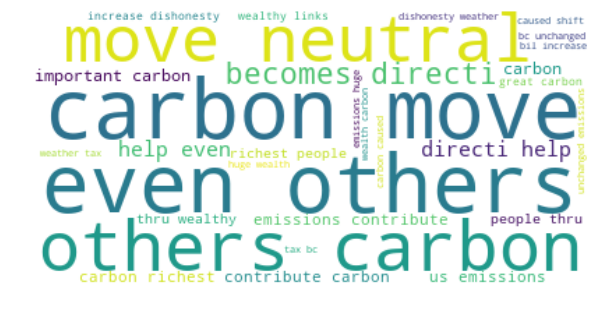

Negative tweets


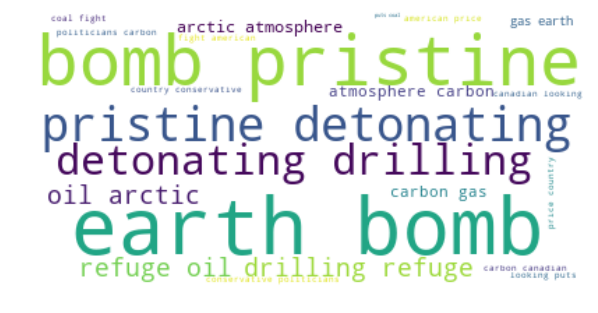

Neutral tweets


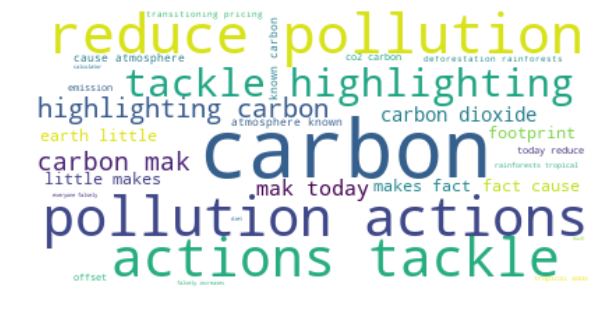

In [123]:
# mainDF.head()
def wordFilterSentiment(term):
    """
    Generate word clouds based on some filtering term, that filters entire mainDF and then generates topics
    """
    
    tokensList = mainDF["tokens"]
    hashtagList = mainDF["hashtags"]
    filterList = []
    for i, j in zip(tokensList,hashtagList):
        if term in i or term in j:
            filterList.append(True)
        else:
            filterList.append(False)
    allSenti = (mainDF[filterList])
    posSenti = (mainDF[(filterList) & (mainDF["sentiment"] > 0)])
    
    negSenti = (mainDF[(filterList) & (mainDF["sentiment"] < 0)])
    neuSenti = (mainDF[(filterList) & (mainDF["sentiment"] == 0)])
    res = {"all": allSenti,"pos" : posSenti, "neg":negSenti, "neu":neuSenti}
    return res

protestFilter = wordFilterSentiment("carbon")


# a = np.hstack()
_ = plt.hist(protestFilter['all']["sentiment"], bins=40)  # arguments are passed to np.histogram
plt.title("Histogram for Vader Sentiment Scores for 'protest'")
plt.show();


create_word_cloud(" ".join((list(itertools.chain.from_iterable(protestFilter['all']["tokens"])))), "Positive tweets")
create_word_cloud(" ".join((list(itertools.chain.from_iterable(protestFilter['pos']["tokens"])))), "Positive tweets")
create_word_cloud(" ".join((list(itertools.chain.from_iterable(protestFilter['neg']["tokens"])))), "Negative tweets")
create_word_cloud(" ".join((list(itertools.chain.from_iterable(protestFilter['neu']["tokens"])))), "Neutral tweets")


    